# Notebook to format data from "A public domain dataset for human activity recognition using smartphones", Anguita et al (2013).

Data can be found [here](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions).

[Leaderboard](https://paperswithcode.com/dataset/har)

[Paper](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/HAR'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/HAR'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
acc_fps = glob.glob(raw_data_dir + '/RawData/acc*.txt')
gyr_fps = glob.glob(raw_data_dir + '/RawData/gyr*.txt')
annotations_fp = os.path.join(raw_data_dir, 'RawData', 'labels.txt')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 50
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'HAR'

In [6]:
## Get clip ids, and check that they are the same from the acc and gyr files
## eg '/home/jupyter/behavior_data_local/data/raw/HAR/RawData/acc_exp58_user29.txt' -> 'exp58_user29'

acc_clip_ids = sorted(set([x.split('/')[-1].split('.')[0][4:] for x in acc_fps]))
gyr_clip_ids = sorted(set([x.split('/')[-1].split('.')[0][5:] for x in gyr_fps]))

assert acc_clip_ids == gyr_clip_ids

clip_ids = acc_clip_ids
dataset_metadata['clip_ids'] = clip_ids

In [7]:
## Integer codes for individuals

clip_id_to_individual_id = {clip_id : int(clip_id.split('_')[1][4:]) for clip_id in clip_ids}
individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

dataset_metadata['individual_ids'] = individuals # There are 14 individuals but only 13 mentioned in the paper
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [8]:
# Set up data splits by individual
# We use the 70/30 split from the dataset to divide dev / test
# We further split into 60/10/30 train/val/test for supervised training

train_ids_fp = '/home/jupyter/behavior_data_local/data/raw/HAR/Train/subject_id_train.txt'
test_ids_fp = '/home/jupyter/behavior_data_local/data/raw/HAR/Test/subject_id_test.txt'

train_individuals = sorted(set(pd.read_csv(train_ids_fp, header = None)[0]))
dev_individuals = sorted(set(pd.read_csv(train_ids_fp, header = None)[0]))
test_individuals = sorted(set(pd.read_csv(test_ids_fp, header = None)[0]))

val_proportion = .1
num_individuals = len(dev_individuals) + len(test_individuals)

val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(1280)
val_individuals = list(rng.choice(train_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()

for i in val_individuals:
    train_individuals.remove(i)
    
print(dev_individuals)    
print(train_individuals)
print(val_individuals)
print(test_individuals)

[1, 3, 5, 6, 7, 8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30]
[1, 3, 5, 6, 7, 8, 11, 14, 15, 16, 17, 19, 21, 23, 25, 26, 28, 30]
[22, 27, 29]
[2, 4, 9, 10, 12, 13, 18, 20, 24]


In [9]:
# Set up clip ids 

dev_clip_ids = []
test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

In [10]:
## Integer codes for specific behaviors

# list of behaviors, see activity_labels.txt
beh_names = ['unknown', 
             'WALKING',
             'WALKING_UPSTAIRS',
             'WALKING_DOWNSTAIRS',
             'SITTING',
             'STANDING',
             'LAYING',
             # 'STAND_TO_SIT',
             # 'SIT_TO_STAND',
             # 'SIT_TO_LIE',
             # 'LIE_TO_SIT',
             # 'STAND_TO_LIE',
             # 'LIE_TO_STAND',
            ]

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

In [11]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'GyrX', 'GyrY', 'GyrZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [12]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [13]:
# Following README.txt, we remove gravitational bias from each accel channel by applying a 
# butterworth filter with cutoff frequency of 0.3 Hz, then subtract the result

def smooth(series, smoothing_cutoff_freq):
    # smooth
    sos = signal.butter(10, smoothing_cutoff_freq, 'low', fs = sr, output = 'sos')
    series = signal.sosfilt(sos, series)
    return series

def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

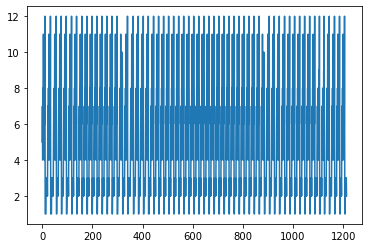

In [14]:
# load up annotations

annotations_fp = os.path.join(raw_data_dir, 'RawData', 'labels.txt')
annotations = pd.read_csv(annotations_fp, delimiter = ' ', header = None, names = ['exp_id','ind_id','label','start_sample','end_sample'])
plt.plot(annotations['label'])

In [15]:
# For each clip, create and save the data in the correct format

for clip_id in clip_ids:
    # load features
    acc_fp = os.path.join(raw_data_dir, 'RawData', 'acc_' + clip_id + '.txt')
    gyr_fp = os.path.join(raw_data_dir, 'RawData', 'gyro_' + clip_id + '.txt')
    
    acc_data = pd.read_csv(acc_fp, delimiter = ' ', header = None)
    gyr_data = pd.read_csv(gyr_fp, delimiter = ' ', header = None)
    static_acc_data = acc_data.copy()
    
    clip_dur_samples = len(acc_data)
    
    # correct for gravity
    for i in range(3): #first 3 channels are acceleration
        to_correct = np.array(acc_data[i])
        to_correct = smooth(to_correct, 20.)
        static, corrected = extract_static(to_correct, 0.3) # 0.3 Hz following description in Readme
        acc_data[i] = corrected
        static_acc_data[i] = static
        
        to_smooth_gyr = np.array(gyr_data[i])
        smoothed = smooth(to_smooth_gyr, 20.)
        gyr_data[i] = smoothed
        
    acc_data = np.array(acc_data)
    gyr_data = np.array(gyr_data)
    static_acc_data = np.array(static_acc_data)
    
    exp_id = int(clip_id[3:5])
    annotations_sub = annotations[annotations['exp_id'] == exp_id]
    
    # reformat annotations
    per_frame_annotations = np.zeros([clip_dur_samples, 1]) # populate with 0's, aka "unknown"
    for i, row in annotations_sub.iterrows():
        obs_int_label = row['label']
        int_label = obs_int_label if obs_int_label < 7 else 0 # Treat transitional states as unknown
        start_sample = row['start_sample']
        end_sample = row['end_sample']
        per_frame_annotations[start_sample: end_sample, :] = int_label

    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    clip_data = np.concatenate([acc_data, static_acc_data, gyr_data, per_frame_individual_id, per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
    np.save(clip_data_fp, clip_data)
    

In [16]:
annotations_sub

,exp_id,ind_id,label,start_sample,end_sample
1194,61,30,5,574,1622
1195,61,30,7,1623,1838
1196,61,30,4,1839,2772
1197,61,30,8,2773,2900
1198,61,30,5,2901,4197
1199,61,30,11,4198,4446
1200,61,30,6,4447,5657
1201,61,30,10,5658,5896
1202,61,30,4,5897,7165
1203,61,30,9,7166,7457


## Check it all looks ok

In [165]:
clip_id = clip_ids[12]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)

In [166]:
np.shape(data)

(17195, 11)

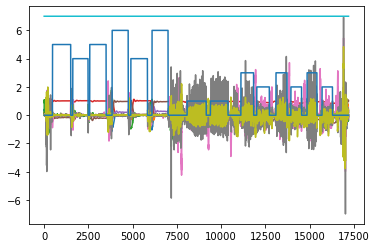

In [167]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, i])

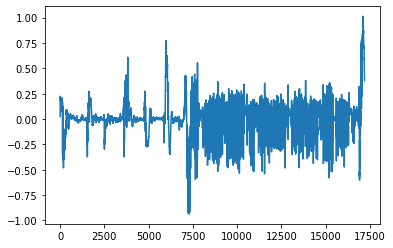

In [168]:
plt.plot(data[:,1])

In [169]:
import librosa

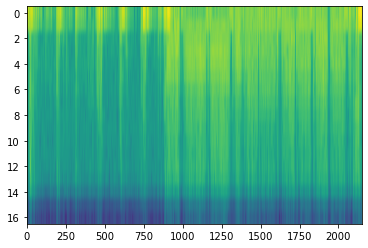

In [170]:
y = np.log(np.abs(librosa.stft(data[:, 1], n_fft = 32)) + 1e-6)
plt.imshow(y, aspect='auto')

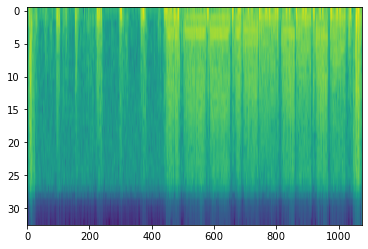

In [171]:
y = np.log(np.abs(librosa.stft(data[:, 8], n_fft = 64)) + 1e-6)
plt.imshow(y, aspect='auto')

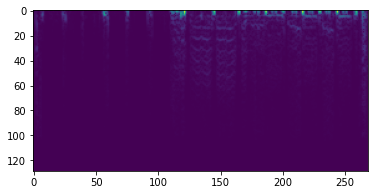

In [172]:
y = np.abs(librosa.stft(data[:, 6], n_fft = 256))
plt.imshow(y)#, aspect='auto')

In [ ]:
clip_id = clip_ids[12]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)
n_fft = 256
z = np.stack((librosa.stft(data[:, 7] , n_fft = n_fft), librosa.stft(data[:, 1], n_fft = n_fft), librosa.stft(data[:, 2], n_fft = n_fft)), axis = -1)
z = np.abs(z)
z = z - np.amin(z, axis = (0,1), keepdims = True)
z = z / np.amax(z, axis = (0,1), keepdims = True)
plt.imshow(z[:,:, 0], aspect = 'auto')

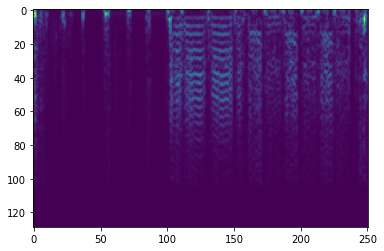

In [207]:
clip_id = clip_ids[13]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)
n_fft = 256
z = np.stack((librosa.stft(data[:, 7] , n_fft = n_fft), librosa.stft(data[:, 1], n_fft = n_fft), librosa.stft(data[:, 2], n_fft = n_fft)), axis = -1)
z = np.abs(z)
z = z - np.amin(z, axis = (0,1), keepdims = True)
z = z / np.amax(z, axis = (0,1), keepdims = True)
plt.imshow(z[:,:, 0], aspect = 'auto')

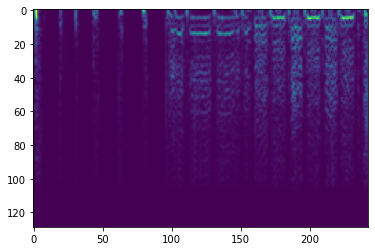

In [208]:
clip_id = clip_ids[14]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)
n_fft = 256
z = np.stack((librosa.stft(data[:, 7] , n_fft = n_fft), librosa.stft(data[:, 1], n_fft = n_fft), librosa.stft(data[:, 2], n_fft = n_fft)), axis = -1)
z = np.abs(z)
z = z - np.amin(z, axis = (0,1), keepdims = True)
z = z / np.amax(z, axis = (0,1), keepdims = True)
plt.imshow(z[:,:, 0], aspect = 'auto')

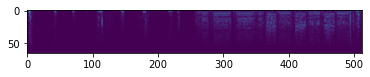

In [211]:
clip_id = clip_ids[15]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.npy')
data = np.load(clip_data_fp)
n_fft = 128
z = np.stack((librosa.stft(data[:, 7] , n_fft = n_fft), librosa.stft(data[:, 1], n_fft = n_fft), librosa.stft(data[:, 2], n_fft = n_fft)), axis = -1)
z = np.abs(z)
z = z - np.amin(z, axis = (0,1), keepdims = True)
z = z / np.amax(z, axis = (0,1), keepdims = True)
plt.imshow(z[:,:, 0])